<a href="https://colab.research.google.com/github/gargidutta0602/Transfer-Learning_Gender-Classification/blob/main/Gender_Classification_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import warnings
warnings.filterwarnings("ignore")

### **Loading Libraries**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout,Flatten, Dense
from keras.layers import BatchNormalization
from keras.optimizers import Adam,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import cv2
import glob

**Downloading Data**

In [4]:
_URL = 'https://gitlab.com/accredian/insaid-data/-/raw/main/Term%2011%20-%20Computer%20Vision/Project%209_%20Classification%20-%20Gender%20classification%20using%20Image/data.zip'
path_to_zip = tf.keras.utils.get_file('data.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'data')

train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

BATCH_SIZE = 16
IMG_SIZE = (160,160)


11594301/11594301 [==============================] - 0s 0us/step


In [5]:
test_dir

'/root/.keras/datasets/data/test'

In [6]:
train_dir

'/root/.keras/datasets/data/train'

In [7]:
train_dataset = image_dataset_from_directory(train_dir,validation_split=0.2,subset="training",seed=123,shuffle=True,batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 442 files belonging to 2 classes.
Using 354 files for training.


In [8]:
validation_dataset = image_dataset_from_directory(train_dir,subset="validation",validation_split=0.2,seed = 123,batch_size=BATCH_SIZE,image_size=IMG_SIZE)

Found 442 files belonging to 2 classes.
Using 88 files for validation.


In [9]:
validation_dataset.class_names

['man', 'woman']

In [10]:
test_dataset = image_dataset_from_directory(test_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 250 files belonging to 2 classes.


In [12]:
test_dataset.class_names

['man', 'woman']

# Now we will print the first 9 Images and their Lebels from the training dataset

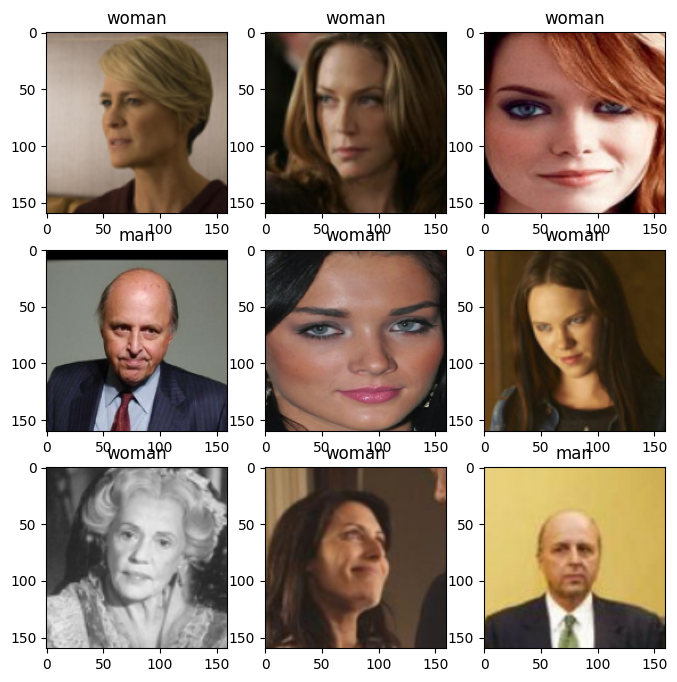

In [13]:
class_names = train_dataset.class_names

plt.figure(figsize=(8,8))

for images,labels in train_dataset.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis()

# **Configuring the Dataset for Performance**

#### **Configuring the Dataset for Performance**

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
#test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#### **Using Data Augmentation**

In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

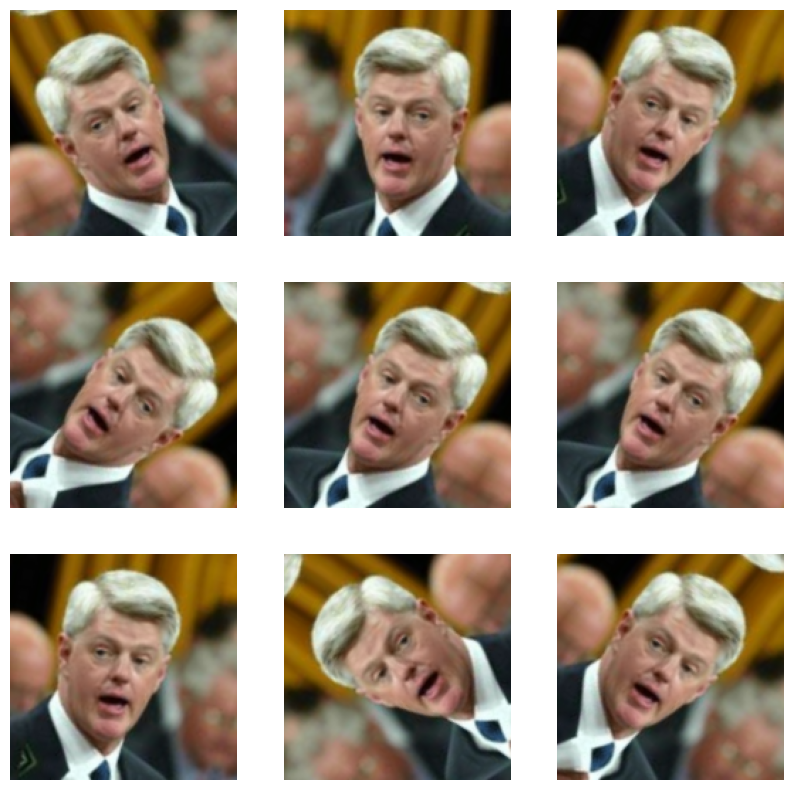

In [16]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

#### **Rescaling Pixel Values**

In [17]:
#preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset = -1)

## **Creating the Base Model from the Pre-trained Convnets**

In [18]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [19]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [20]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 5, 5, 1280)


In [21]:
label_batch

<tf.Tensor: shape=(16,), dtype=int32, numpy=array([1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1], dtype=int32)>

### **Feature Extraction**

#### **Freezing the Convolutional Base**

In [22]:
base_model.trainable = False

In [23]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [25]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [26]:
inputs = tf.keras.Input(shape=(160,160,3))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x,training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)


### **Compiling the Model**

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
from keras.callbacks import EarlyStopping


In [29]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)


# **Training the Model**

In [30]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

6/6 [==============================] - 3s 233ms/step - loss: 0.6032 - accuracy: 0.7386


In [31]:
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset,callbacks=[early_stop])

Epoch 1/10
23/23 [==============================] - 13s 353ms/step - loss: 0.5419 - accuracy: 0.7203 - val_loss: 0.2731 - val_accuracy: 0.9091
Epoch 2/10
23/23 [==============================] - 9s 376ms/step - loss: 0.4239 - accuracy: 0.7994 - val_loss: 0.2176 - val_accuracy: 0.9318
Epoch 3/10
23/23 [==============================] - 10s 439ms/step - loss: 0.3399 - accuracy: 0.8333 - val_loss: 0.1873 - val_accuracy: 0.9318
Epoch 4/10
23/23 [==============================] - 9s 403ms/step - loss: 0.3525 - accuracy: 0.8333 - val_loss: 0.1720 - val_accuracy: 0.9432
Epoch 5/10
23/23 [==============================] - 9s 405ms/step - loss: 0.3339 - accuracy: 0.8559 - val_loss: 0.1683 - val_accuracy: 0.9432
Epoch 6/10
23/23 [==============================] - 8s 339ms/step - loss: 0.2823 - accuracy: 0.8814 - val_loss: 0.1587 - val_accuracy: 0.9432
Epoch 7/10
23/23 [==============================] - 9s 399ms/step - loss: 0.3256 - accuracy: 0.8531 - val_loss: 0.1565 - val_accuracy: 0.9432
Epoc

Predictions:
 [1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1]
Labels:
 [1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0]


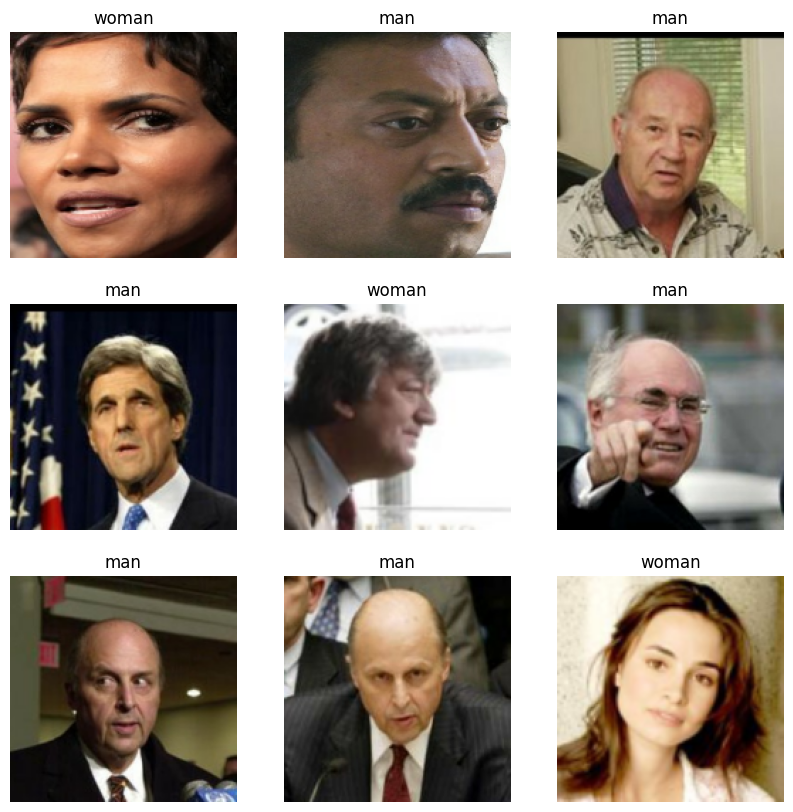

In [32]:
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.3, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

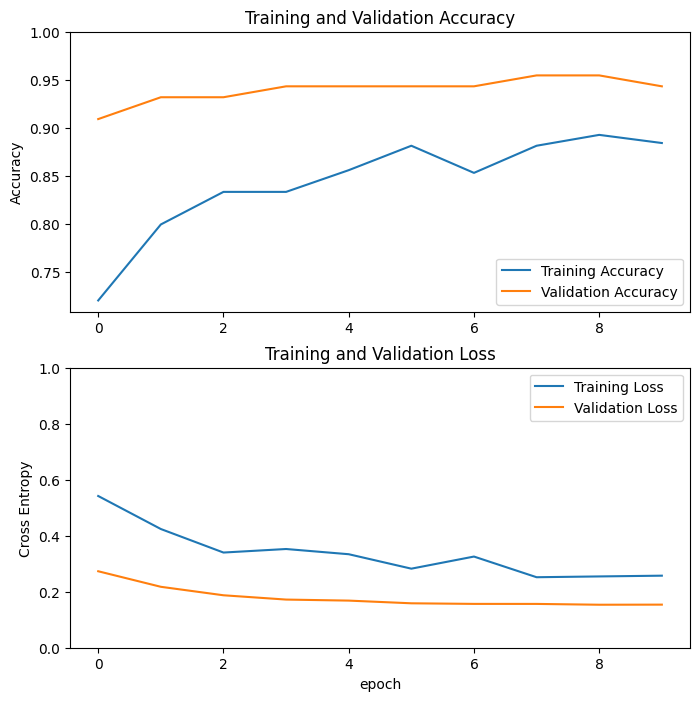

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Text(0.5, 0, 'epoch')

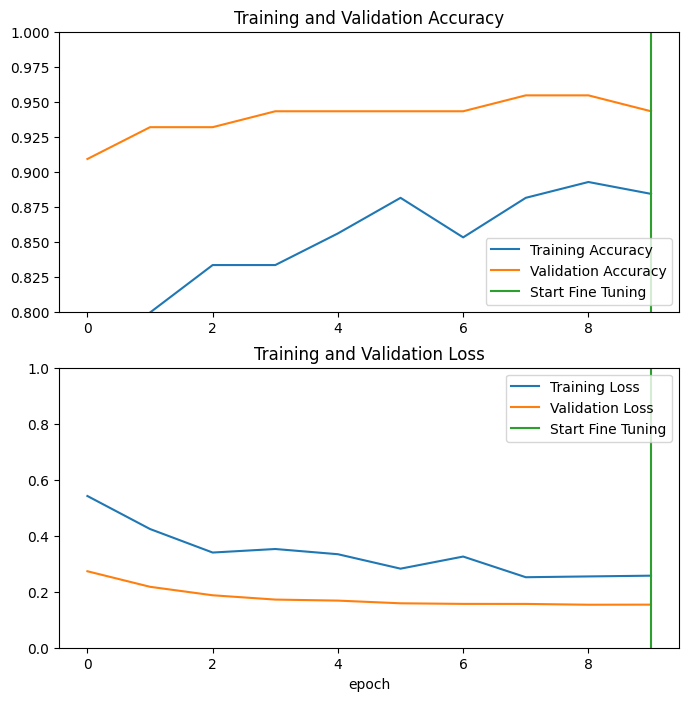

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

### **Fine Tuning the Model**

### **Un-freezing the Top Layers of the Model**

In [35]:
base_model.trainable = True

In [36]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [37]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [38]:
base_model.layers

In [39]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [40]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
23/23 [==============================] - 20s 637ms/step - loss: 0.2558 - accuracy: 0.9068 - val_loss: 0.2950 - val_accuracy: 0.8523
Epoch 11/20
23/23 [==============================] - 14s 599ms/step - loss: 0.1978 - accuracy: 0.9153 - val_loss: 0.1440 - val_accuracy: 0.9545
Epoch 12/20
23/23 [==============================] - 13s 586ms/step - loss: 0.2422 - accuracy: 0.9096 - val_loss: 0.1569 - val_accuracy: 0.9432
Epoch 13/20
23/23 [==============================] - 13s 586ms/step - loss: 0.1571 - accuracy: 0.9294 - val_loss: 0.1406 - val_accuracy: 0.9432
Epoch 14/20
23/23 [==============================] - 12s 526ms/step - loss: 0.1875 - accuracy: 0.9294 - val_loss: 0.1359 - val_accuracy: 0.9545
Epoch 15/20
23/23 [==============================] - 14s 592ms/step - loss: 0.1561 - accuracy: 0.9237 - val_loss: 0.1294 - val_accuracy: 0.9545
Epoch 16/20
23/23 [==============================] - 12s 540ms/step - loss: 0.1910 - accuracy: 0.9181 - val_loss: 0.1863 - val_accuracy:

In [41]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

Text(0.5, 0, 'epoch')

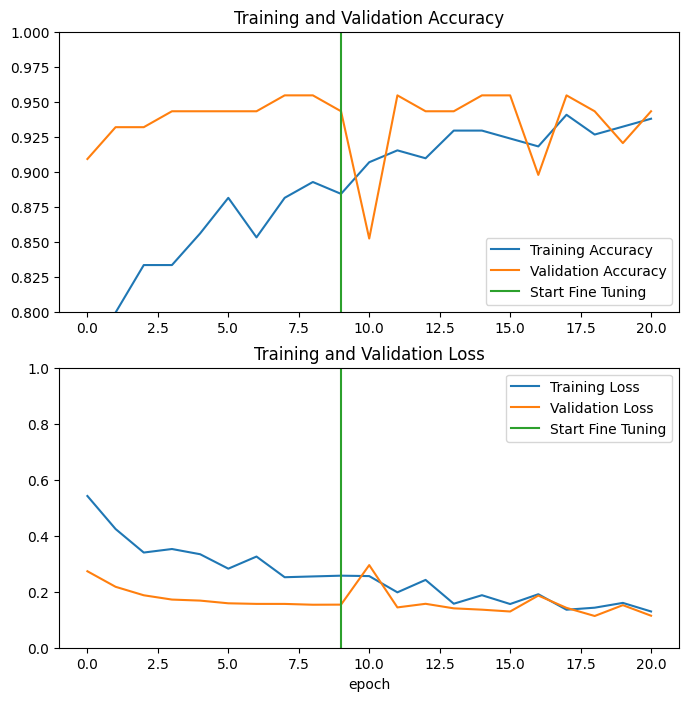

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

Predictions:
 [1 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0]
Labels:
 [1 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0]


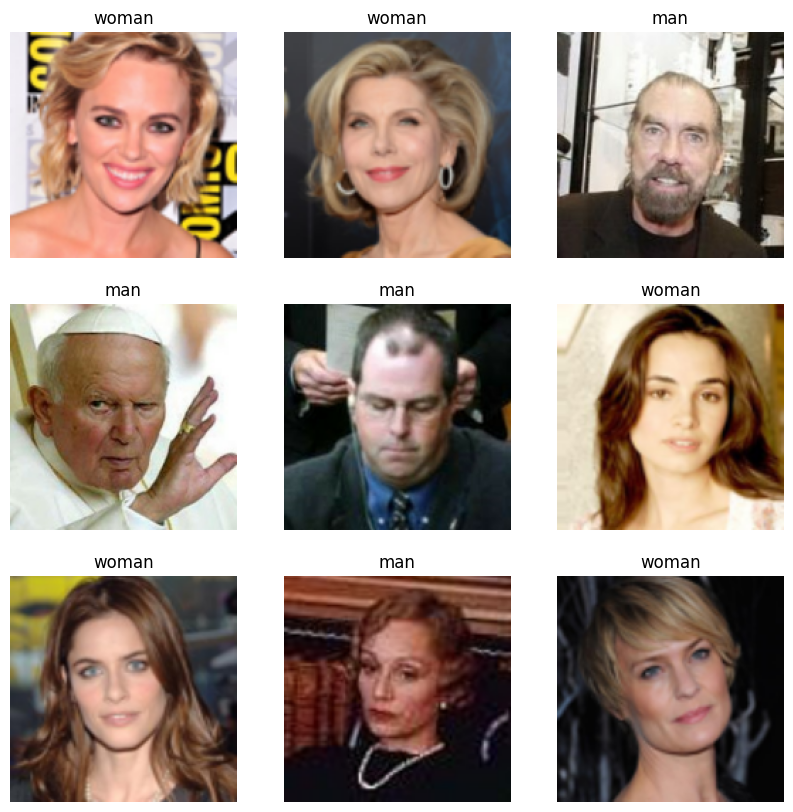

In [43]:
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")